In [1]:
#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
import pandas as pd

In [2]:
#2) Set up exploration class and replay buffer.

class ActionNoise:
    """
        Class: Add noise to our action for exploration
        :param mean: mean of the gaussian noise
        :param std_dev: standard deviation of the gaussian noise
        :param total_episodes: number of steps for training
    """
    def __init__(self, mean, std_deviation,total_episodes):
        self.mean = mean
        self.std_dev = std_deviation
        self.change_ep = std_deviation/(total_episodes)
        
    
    def __call__(self,size):
        """
        Getting noise
        :param size: size of the Tensor with noise values
        :return: Tensor with gaussian noise
        """
        return torch.normal(torch.tensor(self.mean).repeat(size),torch.tensor(self.std_dev).repeat(size))
    
    
    def change_std(self):
        """
        Changing the standard deviation to reduce exploration over time
        """   
        self.std_dev=max(self.std_dev-self.change_ep,0.1)

Transition = namedtuple('Transition',('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    """
        Class: Replay Buffer (RB)
        :param capacity: capacity in memory
    """
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    
    def push(self, *args):
        """
        Save a transition object in RB
        :param args: elements in Transition object
        """
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        """
        Get a sample from RB
        :param batch_size: number of objets in sample
        :return: sample of Transition object
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """
        Get number of saved objets
        :return: number of saved objets
        """
        return len(self.memory)



In [3]:
#3) Set up Neural Network functions and classes

def soft_update(target, source, tau):
    """
        Soft update for a neural network (NN) from an other NN
        :param source: NN used for weights copy
        :param tau: ratio parameter for copy
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    """
        Hard update for a neural network (NN) from an other NN
        :param source: NN used for weights copy ( like soft update with tau=1.0)
    """ 
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

class DDPG_actor(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
        :param model: name of the NN
    """   
    def __init__(self, np_inputs, nb_outputs, model):
        super(DDPG_actor, self).__init__()  
        self.layer1=nn.Linear(np_inputs, 64)
        self.layer2=nn.Linear(64, 64)
        self.layer3=nn.Linear(64, nb_outputs)
        #self.Tanh=nn.Tanh()
        torch.nn.init.uniform_(self.layer3.weight,-0.003, 0.003)
        self.name=model
    
      
    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :return: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        output=F.relu(self.layer1(input1))
        output=F.relu(self.layer2(output))
        output=torch.tanh(self.layer3(output))
        return output
    
class DDPG_critic(nn.Module):
    """
        Class : critic NN
        :param nb_input1: size input state part of the NN (size state)
        :param nb_input2: size input actor part of the NN (size action)
        :param nb_outputs: size output of the NN (size Q_value =1)
        :param model: name of the NN
    """
    def __init__(self, nb_input1, nb_input2, nb_outputs, model):
        
        super(DDPG_critic, self).__init__()  
        self.state_net1=nn.Linear(nb_input1, 48)
        self.state_net2=nn.Linear(48, 48)
        self.action_net1=nn.Linear(nb_input2, 48)
        self.merge_net1=nn.Linear(96, 48)
        self.merge_net2=nn.Linear(48, nb_outputs)
        torch.nn.init.uniform_(self.merge_net2.weight,-0.003, 0.003)
        self.name=model
        
      
    def forward(self, input1, input2):
        """
        Forward NN : compute the NN with respect the current state and action
        :param input1: state
        :param input2: action
        :return: output of the NN, Q_value
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        if isinstance(input2, np.ndarray):
            input2 = torch.tensor(input2, dtype=torch.float)
            
        output1=F.relu(self.state_net1(input1))
        output1=F.relu(self.state_net2(output1))
        output2=F.relu(self.action_net1(input2))
        output3=torch.cat((output1,output2),dim=1)
        output_final=F.relu(self.merge_net1(output3))
        output_final=self.merge_net2(output_final)
        return output_final

In [4]:
#4) Rollout on the environment:
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
    
    def select_action(self, actor_net, state):
        """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :return: action NN, action NN clipped
        """
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    def iterations(self,actor_net, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(nbr_episodes):
            prev_state = env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action, legal_action = self.select_action(actor_net, prev_state)
                    state, reward, done, _ = self.env.step(legal_action.detach().numpy())
                    batch_obs.append(prev_state)
                    batch_acts.append(legal_action.detach().numpy())
                    batch_rews.append(reward)
                    prev_state = state
                if done:
                    break
        return torch.tensor(batch_obs, dtype=torch.float), torch.tensor(batch_acts, dtype=torch.float), torch.tensor(batch_rews, dtype=torch.float)



In [5]:
#5) Algorithm DDPG:
class Algo_DDPG():
    """ 
        PPO algorithm : training and testing
        :param policy_class_a: policy (actor model)
        :param policy_class_c: policy (critic model)
        :param env: environment
        :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class_a, policy_class_c, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class_a(num_states, num_actions, "online")
        self.critic_net = policy_class_c(num_states, num_actions, 1, "online")
        self.target_actor_net = policy_class_a(num_states, num_actions, "target")
        self.target_critic_net = policy_class_c(num_states, num_actions, 1, "target")
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr)#,weight_decay=0.01)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.rollout = Env_rollout(env, self.max_steps)
    
    def evaluate(self, nbr_episodes, selection):
        """
        Testing
        :param nbr_episodes: episode number 
        :param selection: target or current policy NN
        :return: state batch, action batch, and reward batch
        """
        if(selection=="target"):
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.target_actor_net, nbr_episodes)
        else:
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def optimize_model(self):
        """
        Model Optimization
        :return: batch reward
        """
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        criterion=nn.MSELoss(reduction='mean')
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)
        
        #Critic optimization
        self.optimizer_critic.zero_grad()
        target_actor_batch = self.target_actor_net.forward(next_state_batch)
        target_critic_batch = self.target_critic_net.forward(next_state_batch,target_actor_batch.detach())
        critic_action_batch = self.critic_net.forward(state_batch,action_batch)
        expected_state_action_values = (torch.mul(target_critic_batch, 1 - done_batch) * self.gamma) + reward_batch
        critic_loss = criterion(expected_state_action_values.detach(),critic_action_batch)
        critic_loss.backward()
        self.optimizer_critic.step()

        #Actor optimization
        #see if i can optimize only some times
        actor_batch = self.actor_net.forward(state_batch)
        critic_actor_batch = self.critic_net.forward(state_batch,actor_batch)
        actor_loss = - critic_actor_batch.mean()
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        return reward_batch
    
    def select_action(self, actor_net, state, noise):
        """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :param noise: noise object
        :return: action NN, action NN clipped
        """
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        actor_net.train()
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        if(noise is not None):
            action=action+noise(1)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    def train(self, nb_loop):
        """ 
        Training
        :param nb_loop: step number
        """
        self.noise = ActionNoise(self.mean_dev, self.std_dev, nb_loop)
        for i in range(10):
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward], device=device)#+episodic_reward
                done_t = torch.tensor([int(done)])
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(done_t, dim=0))
                if done:
                    break
        n_step=0
        while n_step<nb_loop:
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward])#+episodic_reward
                done_t = torch.tensor([int(done)])
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(done_t, dim=0)
                                )
                prev_state = state
                n_step=n_step+1
                self.total_loop= self.total_loop +1
                self.noise.change_std()
                if (n_step%10==0): #policy delay=2
                    batch_rew2=self.optimize_model()
                    soft_update(self.target_critic_net,self.critic_net,self.tau)
                    soft_update(self.target_actor_net,self.actor_net,self.tau)
                    #if(batch_rew2 != None):
                    #    self.ep_reward_list.append(batch_rew2.mean().detach().numpy())
                if (n_step%2000==0):
                    state_batch, action_batch, rewards_batch = self.rollout.iterations(self.target_actor_net, 30)
                    self.ep_reward_list.append(rewards_batch.mean().numpy())
                    avg_reward = np.mean(self.ep_reward_list[-10:])
                    print("Steps * {} * Avg Reward is ==> {}".format(n_step, avg_reward))
                    #hard_update(self.critic_net,self.target_critic_net)
                    #hard_update(self.actor_net,self.target_actor_net)
                if done:
                    break
        path='load_model/parameters/ddpg-{num_algo:02d}-{name}-{epoch:03d}000.npy'
        with open(path.format(num_algo=self.num_algo,epoch=int(self.total_loop/1000),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.batch_size = 100
        self.memory = ReplayMemory(1000000)
        self.tau = 0.005
        self.gamma = 0.99
        self.mean_dev = 0.0
        self.std_dev = 0.5
        self.max_steps = 90
        self.total_loop = 0
        self.critic_lr = 3e-3
        self.actor_lr = 3e-4
        self.ep_reward_list=[]
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: step number
        """
        self.num_algo = num_algo
        self.total_loop = total_loop
        checkpoint_path1 = "load_model/weights/torch-ddpg-{num_algo:02d}-actor-{epoch:03d}000.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/torch-ddpg-{num_algo:02d}-critic-{epoch:03d}000.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)))
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        
    def saving(self):
        """
        Saving NN weights 
        """
        checkpoint_path = "load_model/weights/torch-ddpg-{num_algo:02d}-actor-{epoch:03d}000.pth"
        torch.save(self.target_actor_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/torch-ddpg-{num_algo:02d}-critic-{epoch:03d}000.pth"
        torch.save(self.target_critic_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo))
        


In [6]:
#6) Computing part:
# Import environment
problem = "Crosswalk_comparison2-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=32

algo=Algo_DDPG(DDPG_actor, DDPG_critic, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(2,2000000)

C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [ ]:
#Training
import time
start = time.process_time()
algo.train(2000000)
algo.saving()
end = time.process_time()
print("Running time: "+str(end-start))

Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Steps * 2000 * Avg Reward is ==> -130.90892028808594
Accident!
Steps * 4000 * Avg Reward is ==> -159.44293212890625
Steps * 6000 * Avg Reward is ==> -166.8578643798828
Steps * 8000 * Avg Reward is ==> -161.15585327148438
Accident!
Accident!
Accident!
Accident!
Steps * 10000 * Avg Reward is ==> -141.3954315185547
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Steps * 12000 * Avg Reward is ==> -119.4259033203125
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Steps * 14000

Steps * 188000 * Avg Reward is ==> -3.2600059509277344
Accident!
Steps * 190000 * Avg Reward is ==> -3.2235217094421387
Steps * 192000 * Avg Reward is ==> -3.19690203666687
Steps * 194000 * Avg Reward is ==> -3.1458756923675537
Steps * 196000 * Avg Reward is ==> -3.1149182319641113
Accident!
Steps * 198000 * Avg Reward is ==> -3.044499158859253
Steps * 200000 * Avg Reward is ==> -3.0405430793762207
Accident!
Steps * 202000 * Avg Reward is ==> -3.032745838165283
Steps * 204000 * Avg Reward is ==> -3.0102994441986084
Accident!
Steps * 206000 * Avg Reward is ==> -3.027681350708008
Steps * 208000 * Avg Reward is ==> -3.075575351715088
Accident!
Steps * 210000 * Avg Reward is ==> -3.095008373260498
Steps * 212000 * Avg Reward is ==> -3.1308107376098633
Steps * 214000 * Avg Reward is ==> -3.188530445098877
Steps * 216000 * Avg Reward is ==> -3.2078375816345215
Accident!
Steps * 218000 * Avg Reward is ==> -3.2944083213806152
Steps * 220000 * Avg Reward is ==> -3.258066177368164
Accident!
Acci

In [13]:
algo.loading(12,2000000)

In [8]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(100, "target")
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

In [9]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    """
        Evaluate the episode with general information (average speed, CO2 emission, end-time)
        :param states: state list
        :param LDV: CO2 emission chart
    """
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=torch.mean(ep_reward)
    std_reward=torch.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 6.38 m/s and its standard deviation is 3.34 m/s

The average car acceleration is -0.22 m/s2 and its standard deviation is 1.53 m/s2

The average pedestrian speed is 1.00 m/s2 and its standard deviation is 0.36 m/s2

The average reward is -1.87 and its standard deviation is 2.47

The average CO2 emission is 9897.78mg and its standard deviation is 7298.68 mg

 Average End-times:
Total: 10.14 s
Car: 5.08 s
Pedestrian: 6.48 s


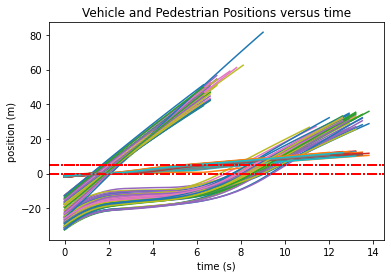

In [10]:

t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

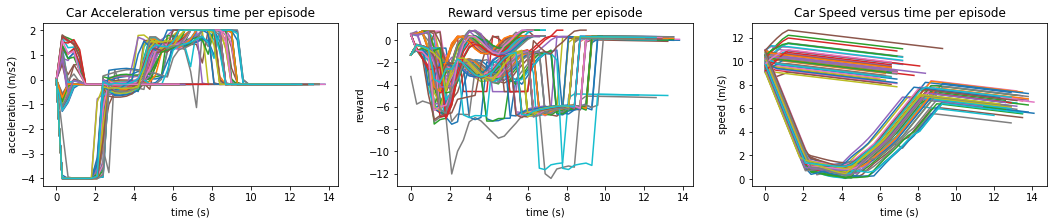

In [11]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1])
    t+=1


In [12]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
size_wait=20
size_cross=50

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1

    if(choice):
        min_l=min(t-t_init,size_cross)
        return_speed=np.array(ep_speed_car[t_init:t_init+min_l])
        return_acc=np.array(states[t_init:t_init+min_l,0])
        if(min_l<size_cross):
            return_speed=np.append(return_speed,[ep_speed_car[t-1]]*(size_cross-t+t_init))
            return_acc=np.append(return_acc,[states[t-1,0]]*(size_cross-t+t_init))
        cross_speed.append(return_speed)
        cross_acc.append(return_acc)
    else:
        min_l=min(t-t_init,size_wait)
        return_speed=np.array(ep_speed_car[t_init:t_init+min_l])
        return_acc=np.array(states[t_init:t_init+min_l,0])
        if(min_l<size_wait):
            return_speed=np.append(return_speed,[ep_speed_car[t-1]]*(size_wait-t+t_init))
            return_acc=np.append(return_acc,[states[t-1,0]]*(size_wait-t+t_init))
        wait_speed.append(return_speed)
        wait_acc.append(return_acc)
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

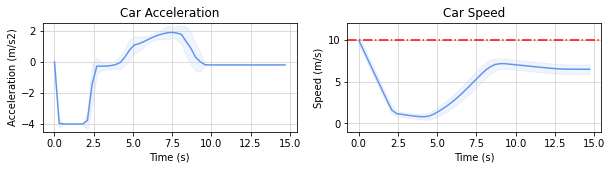

In [13]:
x1=[0.3*i for i in range(size_cross)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
fig.savefig("PDF_results/car_cross_ddpg12.pdf")

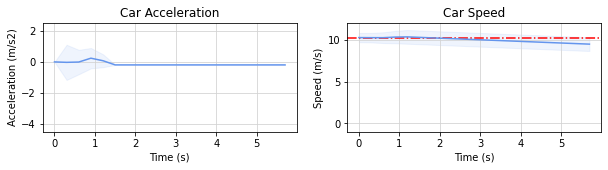

In [14]:
x2=[0.3*i for i in range(size_wait)]

mean_speed2=np.mean(wait_speed,axis=0)
std_speed2=np.std(wait_speed,axis=0)
mean_acc2=np.mean(wait_acc,axis=0)
std_acc2=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x2,mean_acc2,color='cornflowerblue')
ax1.fill_between(x2, (mean_acc2-std_acc2), (mean_acc2+std_acc2), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed2[0], color='r', linestyle='-.')
ax2.plot(x2,mean_speed2,color='cornflowerblue')
ax2.fill_between(x2, (mean_speed2-std_speed2), (mean_speed2+std_speed2), color='cornflowerblue', alpha=0.1)
ax2.grid(True,color='lightgrey')
fig.savefig("PDF_results/car_wait_ddpg12.pdf")

In [19]:
def estimation_value(x1,x2,x3,y1,y3):
    a=(y3-y1)/(x3-x1)
    b=(y1*x3 - y3*x1)/(x3-x1)
    return a*x2+b

def extract_estimations(positions, parameter, start_position, end_position, step_pos):
    size_position=int((end_position-start_position)/step_pos)
    length=len(positions)
    array_cross=np.array([0.0]*size_position)
    i_step=0
    i_pos=start_position
    i=0
    while(i_pos<positions[i_step]):
        array_cross[i]=parameter[i_step]
        i=i+1
        i_pos=i_pos+0.5
    while(i_step<length and i<size_position):
        while( i_step+1<length and i_pos>positions[i_step]):
            i_step=i_step+1
        array_cross[i]=estimation_value(positions[i_step-1],i_pos,positions[i_step],parameter[i_step-1],parameter[i_step])
        i=i+1
        i_pos=i_pos+0.5
    while(i<size_position):
        array_cross[i]=parameter[i_step-1]
        i=i+1
    return array_cross

In [20]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
start_position=-32.5
end_position=32.5
while t+1<len(ep_time):
    
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
        
    if(choice):
        return_speed=extract_estimations(ep_pos_car[t_init:t], ep_speed_car[t_init:t],start_position,end_position,0.5)
        return_acc=extract_estimations(ep_pos_car[t_init:t], ep_action[t_init:t],start_position,end_position,0.5)
        cross_speed.append(return_speed)
        cross_acc.append(return_acc)
        
    else:
        return_speed=extract_estimations(ep_pos_car[t_init:t], ep_speed_car[t_init:t],start_position,end_position,0.5)
        return_acc=extract_estimations(ep_pos_car[t_init:t], ep_action[t_init:t],start_position,end_position,0.5)
        wait_speed.append(return_speed)
        wait_acc.append(return_acc)
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

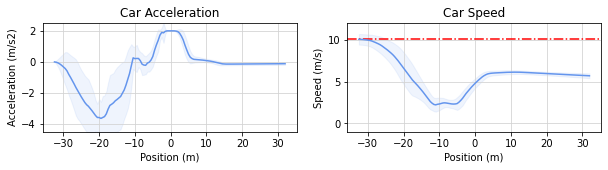

In [21]:
size_position=int((end_position-start_position)/0.5)
x1=[i*0.5+start_position for i in range(0,size_position)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Position (m)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')

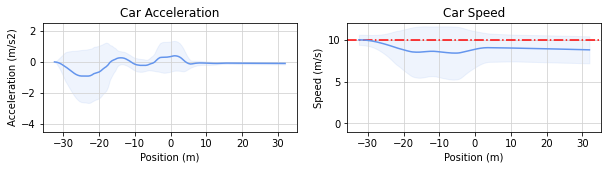

In [22]:
x1=[i*0.5+start_position for i in range(0,size_position)]
mean_speed=np.mean(wait_speed,axis=0)
std_speed=np.std(wait_speed,axis=0)
mean_acc=np.mean(wait_acc,axis=0)
std_acc=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Position (m)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')

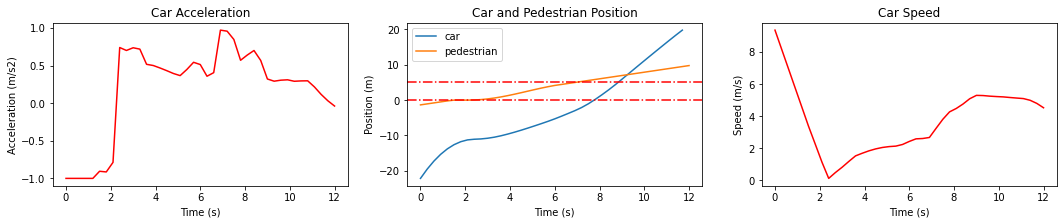

In [22]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode

#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

t+=1